## Knowledge Distillation on MNIST Dataset 

In [127]:
from matplotlib import pyplot
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy

## GPU check

In [128]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Load and Preprocess Dataset

In [129]:
def loadDataset():
  (trainX, trainy), (testX, testy) = mnist.load_data()
  
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))
	
  trainy = trainy
  testy  = testy
  
  train_norm = trainX.astype('float32')/255.0
  test_norm  = testX.astype('float32')/255.0

  return train_norm, trainy, test_norm, testy

In [130]:
trainX, trainy, testX, testy = loadDataset()

### Build the teacher model

In [131]:
teacher = Sequential()
teacher = Sequential(name="Teacher_Model")

teacher.add(Conv2D(32, kernel_size=(3, 3),  activation='relu', kernel_initializer='he_normal', input_shape=(28,28,1)))
teacher.add(MaxPooling2D(pool_size=(2, 2)))
teacher.add(Dropout(0.4))

teacher.add(Flatten())
teacher.add(Dense(256, activation='relu'))
teacher.add(Dropout(0.4))

teacher.add(Dense(128, activation='relu'))
teacher.add(Dropout(0.4))

teacher.add(Dense(32, activation='relu'))
teacher.add(Dropout(0.4))

teacher.add(Dense(10, activation=None))   # This is essential, as we will use the logits for calculating softened probabilites at different T

teacher.compile(
    optimizer=Adam(),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[SparseCategoricalAccuracy()],
)

In [132]:
teacher.summary()

Model: "Teacher_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               1384704   
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)             

### Train the teacher model

In [133]:
teacher.fit(trainX, trainy, epochs=10, batch_size=32, validation_data=(testX, testy), verbose=1)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5955 - sparse_categorical_accuracy: 0.8189 - val_loss: 0.1047 - val_sparse_categorical_accuracy: 0.9710
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2192 - sparse_categorical_accuracy: 0.9466 - val_loss: 0.0756 - val_sparse_categorical_accuracy: 0.9783
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1685 - sparse_categorical_accuracy: 0.9599 - val_loss: 0.0690 - val_sparse_categorical_accuracy: 0.9817
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1348 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.0655 - val_sparse_categorical_accuracy: 0.9842
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1217 - sparse_categorical_accuracy: 0.9718 - val_loss: 0.0618 - val_sparse_categorical_accuracy: 0.9844
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1043 - spars

**The teacher model achieves 98.96% accuracy on test data.**

### Save/Load a model

In [134]:
def saveModel(inp_model, filename):
  inp_model.save(filename)
  return

def loadModel(filename):
  model = load_model(filename)
  return model

In [135]:
# saveModel(teacher, "baseline_fashion_mnist.h5")

## Creating Distiller class

In [136]:
# Reference: https://keras.io/examples/vision/knowledge_distillation/
import keras
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer            : Keras optimizer for the student weights
            metrics              : Keras metrics for evaluation
            student_loss_fn      : Loss function of difference between student predictions and ground-truth
            distillation_loss_fn : Loss function of difference between soft student predictions and soft teacher predictions
            alpha                : weight to distillation_loss_fn and 1-alpha to student_loss_fn
            temperature          : Temperature for softening probability distributions. Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = (1 - self.alpha) * student_loss + self.alpha * (self.temperature ** 2) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"loss": student_loss})
        return results

# Experiment 1

**Q) Can a smaller model get benefit from the dark knowledge ?**

### Create a small student model

In [137]:
# Create the student
def createStudentModel():
  student = Sequential()
  student = Sequential(name="Student_Model")

  student.add(Conv2D(32, kernel_size=(3, 3),  activation='relu', kernel_initializer='he_normal', input_shape=(28,28,1)))
  student.add(MaxPooling2D(pool_size=(2, 2)))

  student.add(Flatten())
  student.add(Dense(128, activation='relu'))
  student.add(Dense(10, activation=None))   # This is essential, as we will use the logits for calculating softened probabilites at different T
  
  return student

In [138]:
temp_student = createStudentModel()
temp_student.summary()

Model: "Student_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_44 (Dense)             (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


### First let's check accuracy of Student model without knowledge distillation

In [139]:
import numpy as np

In [140]:
res = []
iters = 20
for i in range(iters):
  # Clone student for later comparison
  student_scratch = createStudentModel()

  student_scratch.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
  )

  student_scratch.fit(trainX, trainy, epochs=10, batch_size=32, verbose=0)
  res.append(student_scratch.evaluate(testX, testy))

print("Accuracy = ", np.mean(res, axis=0)[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0593 - sparse_categorical_accuracy: 0.9858
Accuracy =  0.9860350012779235


**Student model achieves 98.6% accuracy on test data (without Knowledge Distillation)**

### Now let's try to Distill the knowledge of teacher model into student model

In [141]:
res = []
iters = 20
for i in range(iters):
  # Initialize and compile distiller
  student_distilled = createStudentModel()
  
  distiller = Distiller(student=student_distilled, teacher=teacher)
  distiller.compile(
      optimizer=keras.optimizers.Adam(),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=keras.losses.KLDivergence(),
      alpha=0.2,
      temperature=10,
  )

  distiller.fit(trainX, trainy, epochs=10, batch_size=32, verbose=0)
  res.append(distiller.evaluate(testX, testy))

print("Accuracy = ", np.mean(res))

313/313 [==============================] - 1s 2ms/step - sparse_categorical_accuracy: 0.9886 - loss: 0.0468
Accuracy =  0.9887099981307983


## Using the distilled knowledge from teacher, the stuent is able to achieve accuracy of 98.87%, which is a great improvement over the normal student model (98.6%) and closer to the accuracy attained by the teacher model (98.96%).

- Now, let's see if knowledge distillation helps in regularizing the student model.

In [142]:
from keras.callbacks import History
history = History()

In [143]:
import matplotlib.pyplot as plt

def plotModel(history): 
  fig, axs = plt.subplots(1,2,figsize=(16,5)) 
  # summarize history for accuracy
  axs[0].plot(history.history['sparse_categorical_accuracy'], 'c') 
  axs[0].plot(history.history['val_sparse_categorical_accuracy'],'m') 
  axs[0].set_title('Model Accuracy')
  axs[0].set_ylabel('Accuracy') 
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['train', 'validate'], loc='upper left')
  # summarize history for loss
  axs[1].plot(history.history['loss'], 'c') 
  axs[1].plot(history.history['val_loss'], 'm') 
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss') 
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['train', 'validate'], loc='upper right')
  plt.show()

## Plotting loss and accuracy plots for student model trained from scratch

In [144]:
# Clone student for later comparison
student_scratch = createStudentModel()

student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

student_scratch.fit(trainX, trainy, epochs=10, batch_size=32, validation_data=(testX, testy), verbose=1, callbacks=[History()])

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1361 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.0558 - val_sparse_categorical_accuracy: 0.9809
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0423 - sparse_categorical_accuracy: 0.9866 - val_loss: 0.0516 - val_sparse_categorical_accuracy: 0.9828
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0261 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.0425 - val_sparse_categorical_accuracy: 0.9868
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0161 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.0456 - val_sparse_categorical_accuracy: 0.9865
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0110 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.0493 - val_sparse_categorical_accuracy: 0.9858
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0080 - spars

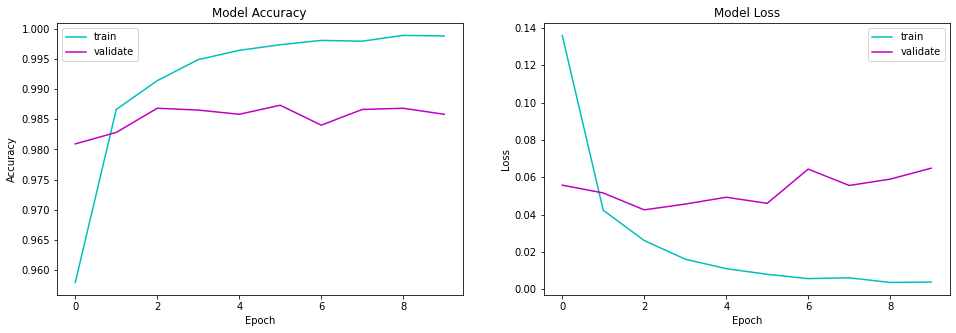

In [145]:
plotModel(student_scratch.history)

## Plotting loss and accuracy plots for student model with KD

In [146]:
# Initialize and compile distiller
student_distilled = createStudentModel()

distiller = Distiller(student=student_distilled, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.2,
    temperature=10,
)

distiller.fit(trainX, trainy, epochs=10, batch_size=32, validation_data=(testX, testy), verbose=1, callbacks=[History()])

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9614 - student_loss: 0.1905 - distillation_loss: 0.0551 - loss: 1.2551 - val_sparse_categorical_accuracy: 0.9809 - val_loss: 0.0124
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - sparse_categorical_accuracy: 0.9865 - student_loss: 0.0539 - distillation_loss: 0.0159 - loss: 0.3621 - val_sparse_categorical_accuracy: 0.9848 - val_loss: 0.0010
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - sparse_categorical_accuracy: 0.9912 - student_loss: 0.0316 - distillation_loss: 0.0101 - loss: 0.2266 - val_sparse_categorical_accuracy: 0.9858 - val_loss: 0.0280
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - sparse_categorical_accuracy: 0.9939 - student_loss: 0.0209 - distillation_loss: 0.0075 - loss: 0.1666 - val_sparse_categorical_accuracy: 0.9877 - val_loss: 0.0011
Epoch 5/10
1875/1875 [==============================] - 7s 3ms/step 

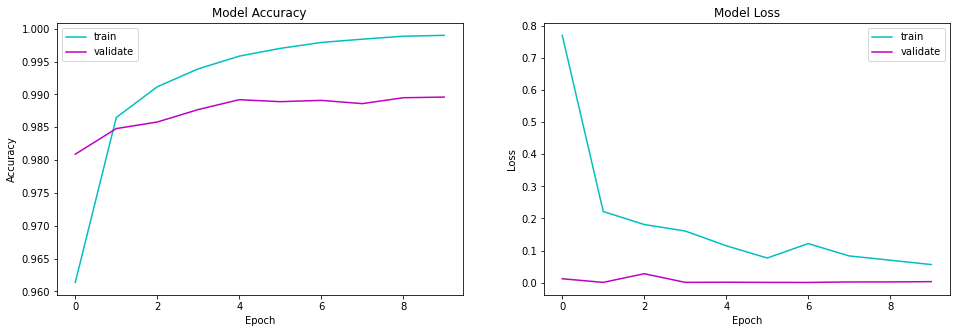

In [147]:
plotModel(distiller.history)